In [ ]:
#!/usr/bin/env python
    
    '''
    RadCLIP Model 2
    '''
    
__author__ = "Andrew D'Amico"
__copyright__ = "Copyright 2023"
__credits__ = ["Andrew D'Amico", "Christoper Alexander", "Katya Nosulko", "Vivek Chamala", "Matthew Conger"]
__license__ = ""
__version__ = "0.0.1"
__maintainer__ = "Andrew Damico"
__email__ = "andrew.damico@u.northwestern.edu"

In [2]:
import itertools
import os

import matplotlib.pyplot as plt
###
import numpy as np
import pandas as pd
import timm
#
import torch
import torch.nn.functional as F
import torchvision.transforms as T
#
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# Callbacks
from torch.utils.tensorboard import SummaryWriter
###
from tqdm import tqdm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

###
from clip_classes import CLIPDataset, get_transforms

2023-06-03 16:04:09.411630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)

# Tensorboard

In [17]:
TOKENIZERS_PARALLELISM = False

In [7]:
writer = SummaryWriter()

# Dataset

In [6]:
folder = "/media/andrew/HD-GDU3/498/"
medical_reports = "cleaned_single_image_only_relevant_headings2.csv"
meta_data = "cleaned_single_image_only_relevant_headings_metadata.csv"
image_data = None
image_folder = None
datasset_folder = "Datasets/"
dataset = "captions.csv"
allsentences = "new_pairs_refined.csv"
md_location = folder + meta_data
meta_reports = pd.read_csv(md_location)
sample = meta_reports.head()

# Set Up Training Parameters

In [8]:
dataset = pd.read_csv(datasset_folder + dataset)
MEAN = torch.tensor([0.47203419, 0.47203419, 0.47203419])  #Image Mean
STD = torch.tensor([0.30503324, 0.30503324, 0.30503324])  #Image STD

In [12]:
class CFG:
    debug = False
    batch_size = 1
    gradient_accumulation_steps = 4
    num_workers = 4
    text_tokenizer = "distilbert-base-uncased"

    head_lr = 3e-5  #1e-3
    image_encoder_lr = 5e-5
    text_encoder_lr = 5e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    IMAGE_MODEL = 'densenet264d'  #'resnet50'
    #IMAGE_MODEL = 'timm/tresnet_xl.miil_in1k_448',
    image_embedding = 4032  #2048

    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768

    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True  # for both image encoder and text encoder
    trainable = True  # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 448

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

## Create Datasets

In [9]:
def update_files(x):
    basename = os.path.basename(x)
    root = '/media/andrew/HD-GDU3/498/images/resized/'

    return (root + basename)

In [10]:
dataset['image'] = dataset['image'].apply(lambda x: update_files(x))
#dataset = dataset.drop(columns='Unnamed: 0')

In [13]:
DATA_FILE = dataset

In [18]:
def get_transforms(mode='train'):
    '''
    Performs image augmentation
    '''
    #transforms = torch.nn.Sequential()

    if mode == 'train':
        transformations = T.Compose([
            #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #T.ToPILImage(),
            #T.RandomHorizontalFlip(p=0.5),
            #T.RandomVerticalFlip(p=0.5),
            #T.RandomAutocontrast(),
            #T.RandomAdjustSharpness(sharpness_factor=2),
            #T.RandomRotation(degrees=(15)),
            T.ToTensor(),
            T.Normalize(mean=MEAN, std=STD),

        ])

    else:
        transformations = T.Compose([
            #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            T.ToTensor(),
            T.Normalize(mean=MEAN, std=STD),
        ])

    #return torch.jit.script(transformations)
    return transformations

In [ ]:
class CLIPDataset(Dataset):

    def __init__(self,
                 image_paths,
                 text,
                 tokenizer,
                 #mode: str = 'train'
                 transformations
                 ):
        self.image_paths = image_paths
        self.captions = list(text)  #already a list?

        self.tokens = tokenizer(
            self.captions,
            padding='max_length',
            truncation=True,
            max_length=CFG.max_length
        )

        self.transforms = transformations  #new

    def __getitem__(self, idx):
        #token = self.tokens[idx]

        item = {
            key: torch.tensor(values[idx])
            for key, values in self.tokens.items()
        }

        #print (item)
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transforms(image)  #['image']
        item['image'] = image
        #item['image'] = image.permute(2, 0, 1).float()
        #item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['pixel_values'] = image
        item['caption'] = self.captions[idx]

        return item

        #return {
        #    'input_ids': token.ids, 
        #    'attention_mask': token.attention_mask,
        #    'pixel_values': image(Image.open(self.image_paths[idx]).convert('RGB'))}

    def __len__(self):
        #return len(self.image_paths)
        return len(self.captions)  #%%

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)

# Tensorboard

In [ ]:
TOKENIZERS_PARALLELISM = False

In [ ]:
writer = SummaryWriter()

# Dataset

In [ ]:
folder = "/media/andrew/HD-GDU3/498/"
medical_reports = "cleaned_single_image_only_relevant_headings2.csv"
meta_data = "cleaned_single_image_only_relevant_headings_metadata.csv"
image_data = None
image_folder = None
datasset_folder = "Datasets/"
dataset = "captions.csv"
allsentences = "new_pairs_refined.csv"
md_location = folder + meta_data
meta_reports = pd.read_csv(md_location)
sample = meta_reports.head()

# Set Up Training Parameters

In [ ]:
dataset = pd.read_csv(datasset_folder + dataset)
MEAN = torch.tensor([0.47203419, 0.47203419, 0.47203419])  #Image Mean
STD = torch.tensor([0.30503324, 0.30503324, 0.30503324])  #Image STD

In [ ]:
class CFG:
    debug = False
    batch_size = 1
    gradient_accumulation_steps = 4
    num_workers = 4
    text_tokenizer = "distilbert-base-uncased"

    head_lr = 3e-5  #1e-3
    image_encoder_lr = 5e-5
    text_encoder_lr = 5e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    IMAGE_MODEL = 'densenet264d'  #'resnet50'
    #IMAGE_MODEL = 'timm/tresnet_xl.miil_in1k_448',
    image_embedding = 4032  #2048

    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768

    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True  # for both image encoder and text encoder
    trainable = True  # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 448

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

## Create Datasets

In [ ]:
def update_files(x):
    basename = os.path.basename(x)
    root = '/media/andrew/HD-GDU3/498/images/resized/'

    return (root + basename)

In [ ]:
dataset['image'] = dataset['image'].apply(lambda x: update_files(x))
#dataset = dataset.drop(columns='Unnamed: 0')

In [ ]:
DATA_FILE = dataset

In [ ]:
def get_transforms(mode='train'):
    '''
    Performs image augmentation
    '''
    #transforms = torch.nn.Sequential()

    if mode == 'train':
        transformations = T.Compose([
            #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #T.ToPILImage(),
            #T.RandomHorizontalFlip(p=0.5),
            #T.RandomVerticalFlip(p=0.5),
            #T.RandomAutocontrast(),
            #T.RandomAdjustSharpness(sharpness_factor=2),
            #T.RandomRotation(degrees=(15)),
            T.ToTensor(),
            T.Normalize(mean=MEAN, std=STD),

        ])

    else:
        transformations = T.Compose([
            #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            T.ToTensor(),
            T.Normalize(mean=MEAN, std=STD),
        ])

    #return torch.jit.script(transformations)
    return transformations

In [ ]:
class CLIPDataset(Dataset):

    def __init__(self,
                 image_paths,
                 text,
                 tokenizer,
                 #mode: str = 'train'
                 transformations
                 ):
        self.image_paths = image_paths
        self.captions = list(text)  #already a list?

        self.tokens = tokenizer(
            self.captions,
            padding='max_length',
            truncation=True,
            max_length=CFG.max_length
        )

        self.transforms = transformations  #new

    def __getitem__(self, idx):
        #token = self.tokens[idx]

        item = {
            key: torch.tensor(values[idx])
            for key, values in self.tokens.items()
        }

        #print (item)
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transforms(image)  #['image']
        item['image'] = image
        #item['image'] = image.permute(2, 0, 1).float()
        #item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['pixel_values'] = image
        item['caption'] = self.captions[idx]

        return item

        #return {
        #    'input_ids': token.ids,
        #    'attention_mask': token.attention_mask,
        #    'pixel_values': image(Image.open(self.image_paths[idx]).convert('RGB'))}

    def __len__(self):
        #return len(self.image_paths)
        return len(self.captions)


In [ ]:
def make_train_valid_dfs(dataframe=DATA_FILE):
    #dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )

    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [ ]:
def build_loaders(
        dataframe,
        tokenizer,
        mode
):
    transforms = get_transforms(mode=mode)

    dataset = CLIPDataset(
        image_paths=dataframe['image'].values,
        text=dataframe['caption'].values,
        tokenizer=tokenizer,
        transformations=transforms
    )

    dataloader = DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )

    return dataloader


In [ ]:
train_df, valid_df = make_train_valid_dfs()

train_loader = build_loaders(
    train_df,
    tokenizer=tokenizer,
    mode="train"
)
valid_loader = build_loaders(
    valid_df,
    tokenizer=tokenizer,
    mode="valid"
)

## Sample Image

In [ ]:
def show_data(batch, idx=0):
    # show image
    #img = batch['image'][idx]
    img = batch['pixel_values'][idx].permute(1, 2, 0)
    img = STD * img + MEAN
    print('Image shape: ', img.shape)

    plt.imshow(img)

    # show text
    text = tokenizer.decode(batch['input_ids'][idx], skip_special_tokens=True)
    print('Text: ', text)

In [ ]:
for item in train_loader:
    #print(item)
    print(item['input_ids'].shape)
    #print(item['pixel_values'].shape)
    break
show_data(item, idx=0)

## Testing Image Model for Shape

In [ ]:
img = Image.open(train_df['image'][0])

In [ ]:
model = timm.create_model(
    'densenet264d',
    #1024 'timm/eva02_large_patch14_448.mim_m38m_ft_in1k',
    #2656 'timm/tresnet_xl.miil_in1k_448',
    #1024 'timm/eva02_large_patch14_448.mim_m38m_ft_in22k',
    #1024 'timm/eva02_large_patch14_448.mim_in22k_ft_in22k',
    #768 'timm/cait_m48_448.fb_dist_in1k',
    #1024 'timm/maxvit_large_tf_512.in1k',
    #2048 'resnet50',
    #1024 'timm/beit_large_patch16_512.in22k_ft_in22k_in1k',
    #2816 'timm/convnextv2_huge.fcmae_ft_in22k_in1k_512',
    pretrained=False,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)



In [ ]:
output.shape

In [ ]:
output = model.forward_features(transforms(img).unsqueeze(0))
# output is unpooled, a (1, 197, 768) shaped tensor

output.shape

# Build Model

### Image Encoder

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(self,
                 model_name=CFG.IMAGE_MODEL,
                 pretrained=CFG.pretrained,
                 trainable=CFG.trainable
                 ):
        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=False,
            num_classes=0,
            global_pool="avg"
        )

        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

### Text Encoder

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self,
                 model_name=CFG.text_encoder_model,
                 pretrained=CFG.pretrained,
                 trainable=CFG.trainable):

        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state

        return last_hidden_state[:, self.target_token_idx, :]

### Projection Head

In [ ]:
class ProjectionHead(nn.Module):

    def __init__(
            self,
            embedding_dim,
            projection_dim=CFG.projection_dim,
            dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)

        return x

### Combine into CLIP Model

In [ ]:
class CLIPModel(nn.Module):

    def __init__(
            self,
            temperature=CFG.temperature,
            image_embedding=CFG.image_embedding,
            text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss = (images_loss + texts_loss) / 2.0  # shape: (batch_size)

        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)

    if reduction == "none":
        return loss

    elif reduction == "mean":
        return loss.mean()


### Configure Training Parameters

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(train_loader, total=len(train_loader))

    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    return loss_meter

In [ ]:
def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)

    return loss_meter

## Build Model

In [ ]:
model = CLIPModel().to(CFG.device)

## Config Optimizer and LR Scheduler

In [ ]:
params = [
    {
        "params": model.image_encoder.parameters(),
        "lr": CFG.image_encoder_lr
    },
    {
        "params": model.text_encoder.parameters(),
        "lr": CFG.text_encoder_lr
    },
    {
        "params": itertools.chain(
            model.image_projection.parameters(),
            model.text_projection.parameters()
        ),
        "lr": CFG.head_lr,
        "weight_decay": CFG.weight_decay
    }
]

optimizer = torch.optim.AdamW(
    params,
    weight_decay=0.01
)

#optimizer = torch.optim.SGD(params, momentum=0.5)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=CFG.patience,
    factor=CFG.factor
)

In [ ]:
step = "epoch"
best_loss = float('inf')

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# Train Model

In [ ]:
for epoch in range(CFG.epochs):
    print(f"Epoch: {epoch + 1}")

    model.train()

    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)

    model.eval()

    with torch.no_grad():
        valid_loss = valid_epoch(model, valid_loader)

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        torch.save(model.state_dict(), "best.pt")
        print("Saved Best Model!")

    lr_scheduler.step(valid_loss.avg)
writer.flush()

In [20]:
def make_train_valid_dfs(dataframe=DATA_FILE):
    #dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )

    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [21]:
def build_loaders(
        dataframe,
        tokenizer,
        mode
):
    transforms = get_transforms(mode=mode)

    dataset = CLIPDataset(
        image_paths=dataframe['image'].values,
        text=dataframe['caption'].values,
        tokenizer=tokenizer,
        transformations=transforms
    )

    dataloader = DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )

    return dataloader


In [22]:
train_df, valid_df = make_train_valid_dfs()

train_loader = build_loaders(
    train_df,
    tokenizer=tokenizer,
    mode="train"
)
valid_loader = build_loaders(
    valid_df,
    tokenizer=tokenizer,
    mode="valid"
)

## Sample Image

In [23]:
def show_data(batch, idx=0):
    # show image
    #img = batch['image'][idx]
    img = batch['pixel_values'][idx].permute(1, 2, 0)
    img = STD * img + MEAN
    print('Image shape: ', img.shape)

    plt.imshow(img)

    # show text
    text = tokenizer.decode(batch['input_ids'][idx], skip_special_tokens=True)
    print('Text: ', text)

torch.Size([1, 200])
Image shape:  torch.Size([448, 448, 3])
Text:  no focal consolidation or gross effusion is identified.


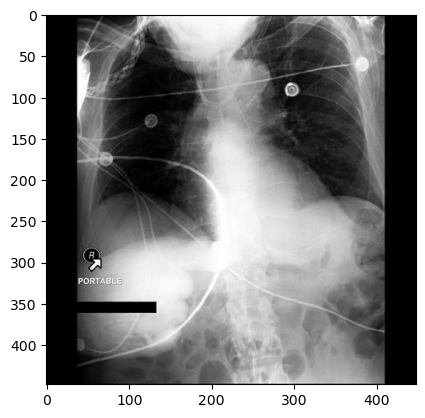

In [24]:
for item in train_loader:
    #print(item)
    print(item['input_ids'].shape)
    #print(item['pixel_values'].shape)
    break
show_data(item, idx=0)

## Testing Image Model for Shape

In [ ]:
img = Image.open(train_df['image'][0])

In [ ]:
model = timm.create_model(
    'densenet264d',
    #1024 'timm/eva02_large_patch14_448.mim_m38m_ft_in1k',
    #2656 'timm/tresnet_xl.miil_in1k_448',
    #1024 'timm/eva02_large_patch14_448.mim_m38m_ft_in22k',
    #1024 'timm/eva02_large_patch14_448.mim_in22k_ft_in22k',
    #768 'timm/cait_m48_448.fb_dist_in1k',
    #1024 'timm/maxvit_large_tf_512.in1k',
    #2048 'resnet50',
    #1024 'timm/beit_large_patch16_512.in22k_ft_in22k_in1k',
    #2816 'timm/convnextv2_huge.fcmae_ft_in22k_in1k_512',
    pretrained=False,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)



In [ ]:
output.shape

In [ ]:
output = model.forward_features(transforms(img).unsqueeze(0))
# output is unpooled, a (1, 197, 768) shaped tensor

output.shape

# Build Model

### Image Encoder

In [27]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(self,
                 model_name=CFG.IMAGE_MODEL,
                 pretrained=CFG.pretrained,
                 trainable=CFG.trainable
                 ):
        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=False,
            num_classes=0,
            global_pool="avg"
        )

        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

### Text Encoder

In [28]:
class TextEncoder(nn.Module):
    def __init__(self,
                 model_name=CFG.text_encoder_model,
                 pretrained=CFG.pretrained,
                 trainable=CFG.trainable):

        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state

        return last_hidden_state[:, self.target_token_idx, :]

### Projection Head

In [29]:
class ProjectionHead(nn.Module):

    def __init__(
            self,
            embedding_dim,
            projection_dim=CFG.projection_dim,
            dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)

        return x

### Combine into CLIP Model

In [30]:
class CLIPModel(nn.Module):

    def __init__(
            self,
            temperature=CFG.temperature,
            image_embedding=CFG.image_embedding,
            text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss = (images_loss + texts_loss) / 2.0  # shape: (batch_size)

        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)

    if reduction == "none":
        return loss

    elif reduction == "mean":
        return loss.mean()


### Configure Training Parameters

In [31]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(train_loader, total=len(train_loader))

    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    return loss_meter

In [32]:
def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)

    return loss_meter

## Build Model

In [ ]:
model = CLIPModel().to(CFG.device)

## Config Optimizer and LR Scheduler

In [34]:
params = [
    {
        "params": model.image_encoder.parameters(),
        "lr": CFG.image_encoder_lr
    },
    {
        "params": model.text_encoder.parameters(),
        "lr": CFG.text_encoder_lr
    },
    {
        "params": itertools.chain(
            model.image_projection.parameters(),
            model.text_projection.parameters()
        ),
        "lr": CFG.head_lr,
        "weight_decay": CFG.weight_decay
    }
]

optimizer = torch.optim.AdamW(
    params,
    weight_decay=0.01
)

#optimizer = torch.optim.SGD(params, momentum=0.5)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=CFG.patience,
    factor=CFG.factor
)

In [35]:
step = "epoch"
best_loss = float('inf')

In [37]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# Train Model

In [ ]:
for epoch in range(CFG.epochs):
    print(f"Epoch: {epoch + 1}")

    model.train()

    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)

    model.eval()

    with torch.no_grad():
        valid_loss = valid_epoch(model, valid_loader)

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        torch.save(model.state_dict(), "best.pt")
        print("Saved Best Model!")

    lr_scheduler.step(valid_loss.avg)
writer.flush()